<a href="https://colab.research.google.com/github/ckbjimmy/2019_tokyo/blob/master/causal_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Microsoft/dowhy.git
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config
!pip install pygraphviz \
 --install-option="--include-path=/usr/include/graphviz" \
 --install-option="--library-path=/usr/lib/graphviz/"
!pip install -r ./dowhy/requirements.txt
!pip install --upgrade pandas
!pip install --upgrade statsmodels
!python ./dowhy/setup.py install

Cloning into 'dowhy'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 527 (delta 90), reused 133 (delta 67), pack-reused 361
Receiving objects: 100% (527/527), 1.22 MiB | 29.84 MiB/s, done.
Resolving deltas: 100% (273/273), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not u

    100% |████████████████████████████████| 7.4MB 4.9MB/s 
  Found existing installation: statsmodels 0.8.0
    Uninstalling statsmodels-0.8.0:
      Successfully uninstalled statsmodels-0.8.0


running install
running bdist_egg
running egg_info
creating dowhy.egg-info
writing dowhy.egg-info/PKG-INFO
writing dependency_links to dowhy.egg-info/dependency_links.txt
writing requirements to dowhy.egg-info/requires.txt
writing top-level names to dowhy.egg-info/top_level.txt
writing manifest file 'dowhy.egg-info/SOURCES.txt'
reading manifest file 'dowhy.egg-info/SOURCES.txt'
writing manifest file 'dowhy.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying dowhy.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying dowhy.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying dowhy.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying dowhy.egg-info/requires.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying dowhy.egg-info/top_level.txt -> build/

In [0]:
import sys
sys.path.append('dowhy')
import numpy as np
import pandas as pd

from dowhy.do_why import CausalModel
import dowhy.datasets

In [0]:
# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

In [3]:
data

{'ate': 10,
 'common_causes_names': ['X0', 'X1', 'X2', 'X3', 'X4'],
 'df':        Z0        Z1        X0        X1        X2        X3        X4    v  \
 0     1.0  0.456371 -0.386229  0.021662 -0.043225  1.363738 -1.059335  1.0   
 1     1.0  0.199405  1.612166 -1.913795  2.104873 -0.005731  0.742911  1.0   
 2     1.0  0.307911  0.438381  0.409440 -2.185253  0.532130 -0.475111  1.0   
 3     0.0  0.178287  0.823704  1.042848 -1.767640  0.610123  1.035724  1.0   
 4     1.0  0.080386  0.813792 -0.238820  0.427877  1.936216 -0.814598  1.0   
 5     1.0  0.926016  0.110606  0.328153 -1.272781  1.716352 -0.360733  1.0   
 6     1.0  0.455115  2.136210  0.423041 -0.156987 -0.122013 -1.292110  1.0   
 7     1.0  0.870973 -1.105938 -1.492268 -1.752109  2.405442  0.226789  0.0   
 8     1.0  0.098148 -0.858814  0.467646 -0.833180  1.413371  0.805732  1.0   
 9     0.0  0.939356  0.088872  0.408396  0.034343  0.327086  0.336910  1.0   
 10    1.0  0.082688 -0.620550 -0.934354  0.271420  0.434

In [4]:
# Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["dot_graph"])

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

# Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

# Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X2', 'Z0', 'Z1', 'U', 'X4', 'X3', 'X0', 'X1'}


['X2', 'Z0', 'Z1', 'U', 'X4', 'X3', 'X0', 'X1']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
no
{'label': 'Unobserved Confounders', 'observed': 'no'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


PropensityScoreMatchingEstimator


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v+X2+Z0+Z1+X4+X3+X0+X1
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v+X2+Z0+Z1+X4+X3+X0+X1+w_random


## dowhy/test mcmc do sampler.ipynb

In [0]:
from dowhy.do_samplers.kernel_density_sampler import KernelDensitySampler
from dowhy.api.causal_data_frame import CausalDataFrame
from statsmodels.api import OLS

In [0]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)

In [0]:
data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # without noise, the variance in Y|X, Z is zero, and mcmc fails.

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


['X0']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler


INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


treatments ['v']
backdoor ['X0']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [y_sd, beta_y, v_sd, beta_v]
100%|██████████| 2000/2000 [00:09<00:00, 214.55it/s]


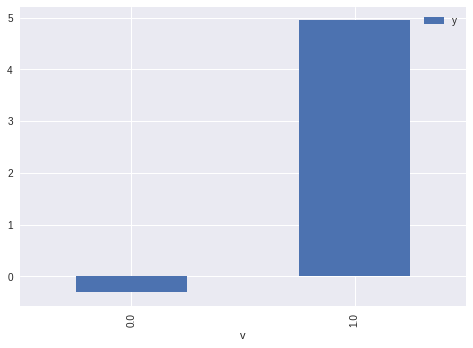

In [8]:
cdf = CausalDataFrame(df)
cdf.causal.do(x={'v': 1}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              common_causes=['X0'],
              keep_original_treatment=True,
              proceed_when_unidentifiable=True).groupby('v').mean().plot(y='y', kind='bar')

In [0]:
cdf = CausalDataFrame(df)

In [10]:
cdf_1 = cdf.causal.do(x={'v': 1}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = cdf.causal.do(x={'v': 0}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True,
              use_previous_sampler=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['X0']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['v']
backdoor ['X0']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [y_sd, beta_y, v_sd, beta_v]
100%|██████████| 2000/2000 [00:06<00:00, 310.06it/s]
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler


In [11]:
cdf_0

,X0,v,y
0,0.539755,0,1.466733
1,1.664484,0,2.274680
2,-0.334733,0,-1.670435
3,0.544009,0,-0.084369
4,-0.376678,0,-1.099705
5,-0.438506,0,-0.546779
6,0.457812,0,0.930814
7,0.031815,0,1.067449
8,0.919677,0,0.387611
9,0.747196,0,1.516240


In [12]:
cdf_1

,X0,v,y
0,0.539755,1,4.594853
1,1.664484,1,5.869783
2,-0.334733,1,5.010684
3,0.544009,1,5.473067
4,-0.376678,1,4.098072
5,-0.438506,1,5.663582
6,0.457812,1,4.632722
7,0.031815,1,6.153207
8,0.919677,1,4.328700
9,0.747196,1,5.651704


In [13]:
cdf_1 = cdf.causal.do(x={'v': 1}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              common_causes=['X0'],
              proceed_when_unidentifiable=True,
              use_previous_sampler=False)
cdf_0 = cdf.causal.do(x={'v': 0}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              common_causes=['X0'],
              proceed_when_unidentifiable=True,
              use_previous_sampler=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['X0']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['v']
backdoor ['X0']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [y_sd, beta_y, v_sd, beta_v]
100%|██████████| 2000/2000 [00:06<00:00, 286.09it/s]
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler


In [14]:
(cdf_1['y'] - cdf_0['y']).mean()

In [15]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(cdf))

In [16]:
model = OLS(df['y'], df[['X0', 'v']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     6853.
Date:                Mon, 18 Feb 2019   Prob (F-statistic):               0.00
Time:                        01:06:38   Log-Likelihood:                -1379.7
No. Observations:                1000   AIC:                             2763.
Df Residuals:                     998   BIC:                             2773.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             0.8511      0.030     28.807      0.000       0.793       0.909
v              4.9613      0.043    114.383      0.000       4.876       5.046
==============================================================================
Omnibus:                        0.534   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.433
Skew:                          -0.040   Prob(JB):                        0.805
Kurtosis:                       3.063   Cond. No.                         1.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
cdf_1

,X0,v,y
0,0.539755,1,5.472456
1,1.664484,1,5.672696
2,-0.334733,1,6.527604
3,0.544009,1,4.703863
4,-0.376678,1,4.136452
5,-0.438506,1,4.578588
6,0.457812,1,5.862724
7,0.031815,1,4.632330
8,0.919677,1,6.579626
9,0.747196,1,6.758529


In [18]:
cdf_0

,X0,v,y
0,0.539755,0,-4.694953
1,1.664484,0,3.450030
2,-0.334733,0,-4.944834
3,0.544009,0,1.548910
4,-0.376678,0,2.818505
5,-0.438506,0,0.977590
6,0.457812,0,0.306381
7,0.031815,0,4.174004
8,0.919677,0,-0.774797
9,0.747196,0,-7.621634


In [19]:
cdf_do = cdf.causal.do(x={'v': 0}, 
              variable_types={'v': 'b', 'y': 'c', 'X0': 'c'}, 
              outcome='y',
              method='mcmc', 
              common_causes=['X0'],
              proceed_when_unidentifiable=True,
              keep_original_treatment=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using McmcSampler for do sampling.


['X0']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
All common causes are observed. Causal effect can be identified.
McmcSampler
treatments ['v']
backdoor ['X0']


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [y_sd, beta_y, v_sd, beta_v]
100%|██████████| 2000/2000 [00:08<00:00, 233.80it/s]


In [20]:
cdf_do

,X0,v,y
0,0.539755,0.0,0.205227
1,1.664484,1.0,5.717509
2,-0.334733,0.0,-0.878724
3,0.544009,0.0,-0.727891
4,-0.376678,1.0,3.135782
5,-0.438506,1.0,4.816487
6,0.457812,1.0,4.560471
7,0.031815,1.0,6.749223
8,0.919677,1.0,4.215825
9,0.747196,0.0,2.907264
